In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nb
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
import random
from matplotlib.pyplot import figure
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

from PIL import Image

from tqdm import tqdm

In [2]:
files=[]
for dirname, _, filenames in os.walk('//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data'):
    for filename in filenames:
      files.append((dirname, filename))
print(len(files))

17999


## Parallel code

In [6]:
import os
import shutil


# Define the parent directory and target directory
parent_dir = "//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data"
target_dir = os.path.join(parent_dir, "Volume")

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

# Define the function to process each segment
def process_segment(segment_index):
    source_dir = os.path.join(parent_dir, f"volume_pt{segment_index}")
    if os.path.exists(source_dir):
        for file_name in os.listdir(source_dir):
            source_file = os.path.join(source_dir, file_name)
            if os.path.isfile(source_file):  # Move files only
                shutil.copy(source_file, target_dir)
    return f"Segment {segment_index} processed."


In [7]:
# pip install jupyter-server-proxy

In [2]:
from dask.distributed import Client
client1 = Client(n_workers=4, threads_per_worker=1, processes=True)
client1

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40995,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:45479,Total threads: 1
Dashboard: http://127.0.0.1:40294/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:42570,


In [24]:
from multiprocessing import Pool
import time
from dask.distributed import Client
import dask
from dask.distributed import performance_report
    # Generate a performance report for the computation
    with performance_report(filename="dask_report"+str(cpus)+".html"):

# Number of CPUs to test
cpu_counts = [1, 2, 4, 8]

# Segments to process
segments = range(1, 9)

execution_times = []
for cpus in cpu_counts:

        print(f"Running with {cpus} CPU(s):")
        start_time = time.time()  # Start the timer
        with Pool(processes=cpus) as pool:
            results = pool.map(process_segment, segments)
        end_time = time.time()  # End the timer
        elapsed_time = end_time - start_time 
        execution_times.append(elapsed_time)
        for result in results:
            print(result)
        print("-" * 50)



Running with 1 CPU(s):
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 2 CPU(s):
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 4 CPU(s):
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 8 CPU(s):
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------


In [8]:
from multiprocessing import Pool
import time
from dask.distributed import Client
import dask
from dask.distributed import performance_report

# CPU counts for testing
cpu_counts = [1, 2, 4, 8]

# Segments to process
segments = list(range(1, 9))  # Convert range to list for Dask compatibility

execution_times = []

for cpus in cpu_counts:
    print(f"Running with {cpus} CPU(s):")
    
    # Initialize Dask Client with the specified number of workers
    with Client(n_workers=cpus) as client:
        print(client)
        # Generate a performance report
        with performance_report(filename=f"performance_report_{cpus}_cpus.html"):
            start_time = time.time()  # Start the timer
            
            # Map the function across segments
            futures = client.map(process_segment, segments)
            results = client.gather(futures)  # Gather results
            
            end_time = time.time()  # End the timer
            elapsed_time = end_time - start_time
            
            execution_times.append(elapsed_time)
            
            # Print results
            for result in results:
                print(result)
            print("-" * 50)

Running with 1 CPU(s):
<Client: 'tcp://127.0.0.1:46467' processes=1 threads=8, memory=40.00 GiB>
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 2 CPU(s):
<Client: 'tcp://127.0.0.1:35224' processes=2 threads=8, memory=40.00 GiB>
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 4 CPU(s):
<Client: 'tcp://127.0.0.1:44100' processes=4 threads=8, memory=40.00 GiB>
Segment 1 processed.
Segment 2 processed.
Segment 3 processed.
Segment 4 processed.
Segment 5 processed.
Segment 6 processed.
Segment 7 processed.
Segment 8 processed.
--------------------------------------------------
Running with 8 CPU(s):
<Client: 'tcp://127.0.0.1:452

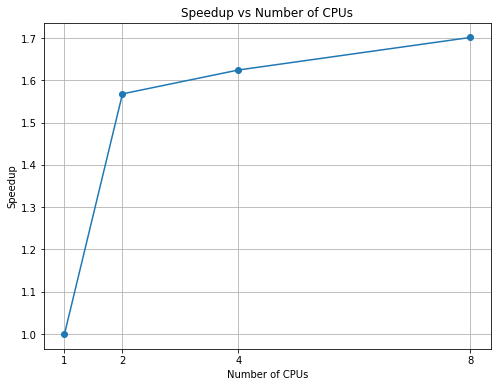

In [28]:
# Calculate speedup relative to single CPU performance
speedups = [execution_times[0] / time for time in execution_times]
# Plotting the speedup
plt.figure(figsize=(8, 6))
plt.plot(cpu_counts, speedups, marker='o')
plt.title('Speedup vs Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(True)
plt.xticks(cpu_counts)
plt.show()

## Parallel code End

In [11]:
vol_dir="//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/Volume/"
seg_dir="//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/segmentations/"

In [12]:
def read_nii(filepath):
    ct_scan = nb.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return(array)

sample = 0
i=0
ct = f"volume-{i}.nii"
seg = f"segmentation-{i}.nii"
sample_ct = read_nii(vol_dir+ ct)

sample_mask = read_nii(seg_dir+seg)

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')


CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


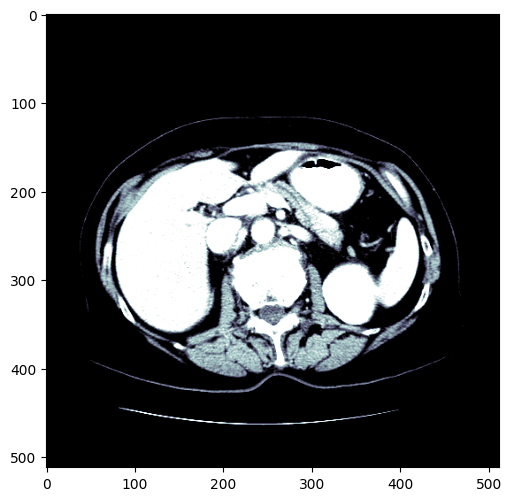

In [13]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)


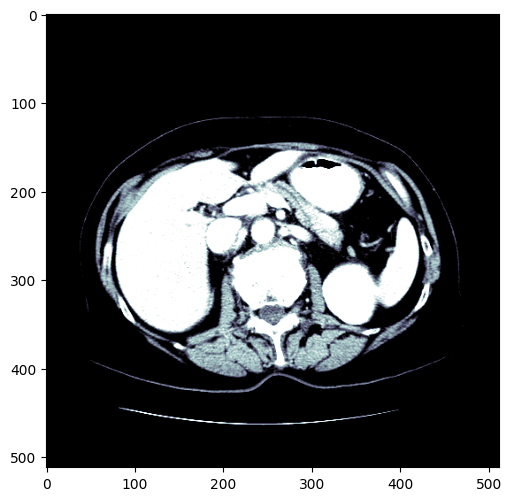

In [14]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone)


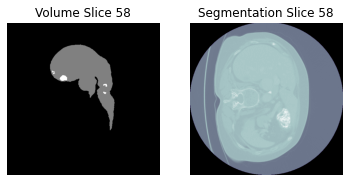

In [15]:
volume_nifti = nib.load('//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/segmentations/segmentation-0.nii')

segmentation_nifti = nib.load('//courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/volume_pt1/volume-0.nii')

volume_data = volume_nifti.get_fdata()
segmentation_data = segmentation_nifti.get_fdata()

slice_index = 58

plt.subplot(1, 2, 1)
plt.imshow(volume_data[..., slice_index], cmap='gray')
plt.title('Volume Slice {}'.format(slice_index))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmentation_data[..., slice_index], cmap='bone')
plt.title('Segmentation Slice {}'.format(slice_index))
plt.axis('off')

plt.show()


In [16]:
def plot_sample(array_list, color_map = 'binary'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')

    plt.show()

In [17]:
def get_ct(idx):
    ct = f"volume-{idx}.nii"
    seg = f"segmentation-{idx}.nii"
    sample_ct = read_nii(vol_dir + ct)
    sample_mask = read_nii(seg_dir + seg)
    return sample_ct, sample_mask

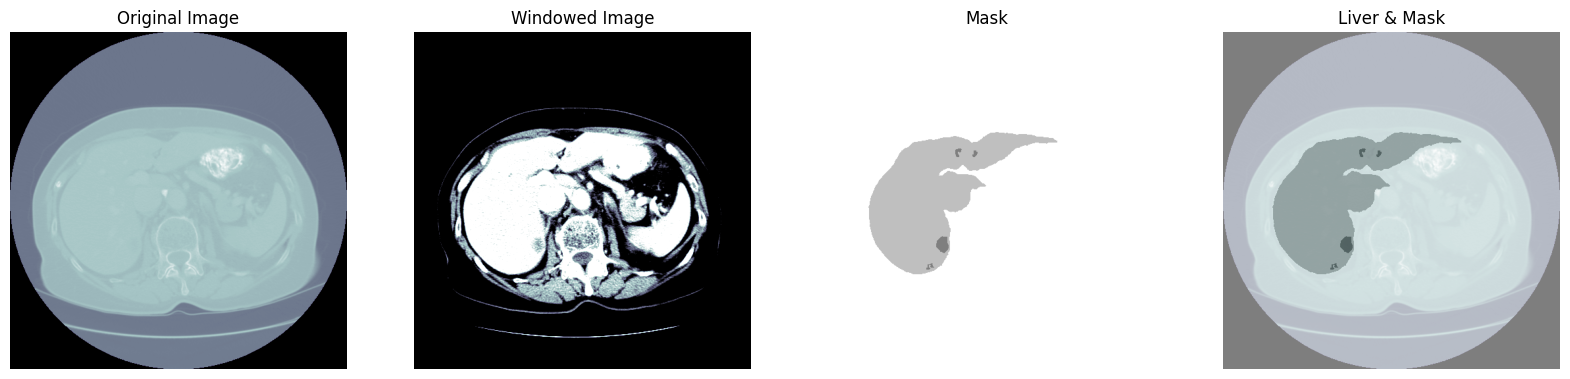

In [18]:
sample = 58
idx = 0
sample_ct, sample_mask = get_ct(idx)

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [19]:
import os

def count_files_hpc(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

print(f"Number of files: {count_files_hpc(vol_dir)}")


Number of files: 131


In [20]:
train_size = round(count_files_hpc(vol_dir)*1/3)
file_count = sum(len(files) for _, _, files in os.walk("//path/to/your/directory"))
val_data_dir = "/courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/val"
val_size = train_size // 2

In [21]:
train_size


44

In [22]:
# def get_ct_and_mask(idx):
#   ct = read_nii(vol_dir+ '/' + f"volume-{idx}.nii")
#   mask = read_nii(seg_dir+ '/' + f"segmentation-{idx}.nii")
#   file_name ="volume-"+str(idx)
#   dim = ct.shape[2]
#   return ct, mask, file_name, dim


# def save_images(from_idx, to_idx, dir):
#   data_dir = dir + '/data'
#   labels_dir = dir + '/labels'
#   if not os.path.exists(data_dir):
#     os.makedirs(data_dir)
#   if not os.path.exists(labels_dir):
#     os.makedirs(labels_dir)
#   for i in tqdm(range(from_idx, to_idx)):
#     curr_ct, curr_mask, curr_file_name, curr_dim = get_ct_and_mask(i)
#     for curr_slice in range(0, curr_dim, 10):
#       data = curr_ct[..., curr_slice]
#       mask = curr_mask[..., curr_slice] * 255 / 2
#       im_data = Image.fromarray(data).convert('L')
#       im_mask = Image.fromarray(mask).convert('L')
#       path_data = f"{data_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
#       path_label = f"{labels_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
#       im_data.save(path_data)
#       im_mask.save(path_label)

In [23]:
# import time

# start_time = time.time()
# save_images(0, train_size, train_data_dir)
# save_images(train_size, train_size + val_size, val_data_dir)

# end_time = time.time()
# print(f"Execution time: {end_time - start_time:.2f} seconds")

In [24]:
def get_ct_and_mask(idx):
  ct = read_nii(vol_dir+ '/' + f"volume-{idx}.nii")
  mask = read_nii(seg_dir+ '/' + f"segmentation-{idx}.nii")
  file_name ="volume-"+str(idx)
  dim = ct.shape[2]
  return ct, mask, file_name, dim

def save_images_task(args):
    """Task wrapper to parallelize save_images."""
    from_idx, to_idx, dir = args
    data_dir = dir + '/data'
    labels_dir = dir + '/labels'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)
    for i in tqdm(range(from_idx, to_idx)):
        curr_ct, curr_mask, curr_file_name, curr_dim = get_ct_and_mask(i)
        for curr_slice in range(0, curr_dim, 10):
            data = curr_ct[..., curr_slice]
            mask = curr_mask[..., curr_slice] * 255 / 2
            im_data = Image.fromarray(data).convert('L')
            im_mask = Image.fromarray(mask).convert('L')
            path_data = f"{data_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
            path_label = f"{labels_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
            im_data.save(path_data)
            im_mask.save(path_label)


In [25]:
cpu_counts = [1, 2, 4, 8]

excuted_times = []


for cpu in cpu_counts:
    train_data_dir = "/courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/train"+str(cpu)

    val_data_dir = "/courses/CSYE7105.202510/students/krishnamurthy.p/Final-Project/data/val"+str(cpu)
    
    tasks = [
        (0, train_size, train_data_dir),
        (train_size, train_size + val_size, val_data_dir)
    ]
    print(f"Running with {cpus} CPU(s):")
    
    # Initialize Dask Client with the specified number of workers
    with Client(n_workers=cpus) as client:
        print(client)
        # Generate a performance report
        with performance_report(filename=f"report_{cpus}_cpus.html"):
            start_time = time.time()
            with Pool(processes = cpu) as pool:
                pool.map(save_images_task, tasks)
            end_time = time.time()
            excuted_times.append(end_time-start_time)

Running with 8 CPU(s):
<Client: 'tcp://127.0.0.1:43634' processes=8 threads=8, memory=40.00 GiB>


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Running with 8 CPU(s):
<Client: 'tcp://127.0.0.1:46573' processes=8 threads=8, memory=40.00 GiB>


100%|██████████| 44/44 [03:33<00:00,  4.85s/it]


Running with 8 CPU(s):
<Client: 'tcp://127.0.0.1:44860' processes=8 threads=8, memory=40.00 GiB>


100%|██████████| 44/44 [03:09<00:00,  4.32s/it]


Running with 8 CPU(s):
<Client: 'tcp://127.0.0.1:46400' processes=8 threads=8, memory=40.00 GiB>


100%|██████████| 44/44 [02:45<00:00,  3.76s/it]


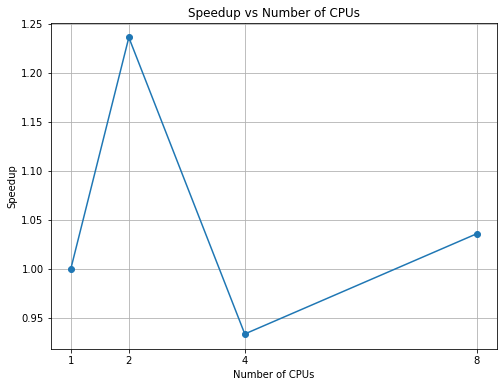

In [21]:
# Calculate speedup relative to single CPU performance
speedups = [excuted_times[0] / time for time in excuted_times]
# Plotting the speedup
plt.figure(figsize=(8, 6))
plt.plot(cpu_counts, speedups, marker='o')
plt.title('Speedup vs Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(True)
plt.xticks(cpu_counts)
plt.show()